In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy import stats
import numpy as np

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

In [75]:
# Блок функций

# Проверка на бытие Наном
def isNaN(num):
    return num != num

# рисовалка боксплотов
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score', data = work_d, ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()
    

# Расчет коэффициента Крамера. Если б я еще понимал, что тут происходит, было бы вообще хорошо. Откуда-то утащена
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [3]:
data = pd.read_csv('stud_math.xls')

In [4]:
# Мысли перед работой. Сначала отсеем данные основываясь на логике, их общей адекватности и применимости.
# Итак, цитирую задание: 
# "Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, 
# чтобы на ранней стадии выявлять студентов, находящихся в группе риска."

# Во-первых, наше исследование общее, нас не интересует в каких конкретно школах учат лучше. Поэтому, хотя корреляция между
# успеваемостью и названием школы скорее всего будет, нас она не интересует. Выкидываем сразу этот столбец. Опять же, если школа
# плоха, то дело не в ученике. И нормировать надо на медианный балл по школе, чтобы сравнивать разные школы.
# Но, само название это пыль. Сегодня эта школа хороша, завтра - плоха. А вот как фактор риска учесть окружение лентяев, негров,
# наркоманов это можно. Для этого вместо вредных и вносящих возможную ошибку в будущее использование нашего анализа, названий школ
# введем новый параметр - средняя успеваемость в школе.

# Во-вторых, хотя мальчики и девочки могут по объективным, сцепленным с полом признакам, иметь разную успеваемость по конкретному
# предмету, в нашем случае математике, это снова лежит вне сферы наших интересов - мы тут всех детей спасаем, а не только лучших.
# Да и ООН же, сейчас там столько полов, что черт ногу сломит, выделять два - нарваться на неприятности.
# Короче, выкидываем сразу и этот столбец - не интересно сейчас. Может быть какая-то хитрая закономерность. Но в таком случае
# мы увидим четкое разделение по одному из признаков нашей унисекс выборки на две, и тогда вернем наш столбец и изучим глубже.
#а для совсем простой проверки
#data.groupby(by = 'sex')['score'].agg('mean')
#получили различие на 4%. Не знаю умного обоснования, но мастерским произволом признаю различие незначительным


# В-третьих, полнота семьи тоже не сыграет. А вот наличие одного дома сидящего родителя, наверняка. Плюс отношения в семье.
# Но это оставляем, просто план на проверку. Может ли наличие домохозяйки полностью покрыть фактор полной\неполной семьи?


# Город\загород. Я думал сначала разделить выборку на город-загород, раз на селе школы точно будут хуже(если это реальный дф),
# но раз я уже учел объективную крутость школы выше, то этот параметр становится избыточным, приминительно к знаниям ребенка.
# удаляем.
# Так. Я посмотрел - в этом дата сете только две школы, и ученики в каждой чуть хуже учатся, если живут загородом. Для данного
# набора данных имело бы смысл оставить этот пункт, а для глобального поиска проблемных учеников, не думаю, поэтому исходя
# из глобальной задачи, убираем этот столбец все равно.

# Причина выбора школы. Удаляем. Во-первых, субъективный параметр, который будет сбивать картину нам. Во-вторых, не взаимоисклю-
# чающие значения. Если человек выбрал школу рядом с домом, не значит, что она плохая. И наоборот, далеко - не значит, что так
# уж хороша, может из двух зол выбирали. А судя по значениям параметра имелось ввиду именно это при опросе - мол выбрали ли
# школу сознательно. Но это опять же будет учтено в более объективном параметре "крутости школы" по среднему балу учеников в ней.
# Еще раз: ищем потенциально недобирающих учеников, не важно как и почему они оказались в этой школе, важно, что это за школа.


# Время в пути до школы. Наверняка скоррелировано как-то с причиной выбора школы, свободным временем, играми, пр.
# Но, поскольку ходить в школу все обязаны, дополнительно есть "количество прогулов", отдельно есть про доп занятия,
# про репетиторов, на что тоже может влиять время поездки. И раз все то, на что это время поездки влияет, есть и так, то мы его 
# тоже выкинем, как избыточную информацию.


# Посещал ли детский сад. Не могу представить ситуации, когда детский сад влияет на успеваемость по математике, да еще при анализе
# с 15 летнего возраста. Если и были какие-то эффекты связанные с социальной адаптацией, они уже сгладились за 8 лет - больше 
# половины жизни ребенка. Поэтому тоже, смело выкидываю. Это возможно будет скоррелированно с чем-то но не с оценкой за 
# математику. Опять же, если это не какой-то уникальный детсад, который при анализе выкинули бы как вылет.


# В романтических ли отношениях. Все через это проходят, 
# да, это влияет на успеваемость в какой-то момент. Но это точно не то, что нужно учитывать при поиске детей, потенциально 
# нуждающихся в помощи. Более того, учитывая крайне переменный, не поддающийся математической обработке характер любви и влюбленности,
# подобный пункт, имея значение да или нет, нам ни о чем не говорит. В "да" может быть: я счастлив, все хорошо. так и: я несчастен, все плохо.
# Тоже самое и в "нет". Нет - и я вообще-то тут делами занимаюсь, или: она меня предала, пойду вены порежу. Слишком сложное это 
# понятие, слишком много в себя включает. Поэтому анализируя этот параметр в таком усеченном виде, мы только усложним системе 
# задачу, вводя очень много шума. Выкидываем.


# failures. Опять субъективная, к тому же непонятная фигня. Для одного неудача - ноготь сломать. Для второго смерть мамы 
# повод пожрать на поминках. Более того, как вы себе представляете этот опросник от ООН? Вот вы ребенок, перед вами вопрос:
# "сколько у тебя было неудач". Ребенок покрутит пальцем у виска и пошлет подальше - будет прав. Неясно, субъективно, снова,
# как и с любовью очень многогранно, нафиг этот пункт.


#guardian. Не ясна функция опекуна, учитывая, что он может присутствовать при полной семье с хорошими отношениями внутри нее.
# Что я не понимаю, то я не могу адекватно анализировать. Выкидываем, чтобы не было лишних искажений. Возможно, он следит
# дополнительно за ребенком. Но опять же - не зная точно, только лишнего тумана напустим.

In [5]:
# А теперь воплощаем наши решения и думаем дальше.
# Вводим новый параметр - средний балл по школе. school_score_av
data.score    #Дает нам понимание, что значений 395, все они float64

0      30.0
1      30.0
2      50.0
3      75.0
4      50.0
       ... 
390    45.0
391    80.0
392    35.0
393    50.0
394    45.0
Name: score, Length: 395, dtype: float64

In [6]:
data.school.value_counts()    #Дает нам понимание, что школы всего две, и пропусков нет, можем работать.

GP    349
MS     46
Name: school, dtype: int64

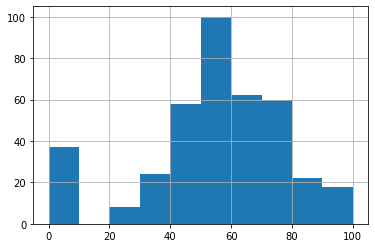

In [7]:
data.score.hist()    # внезапно, сначала гистограмма, а потом и проверка 

In [8]:
data[data.score == 0]    # показывают, что у нас много учеников с нулем баллов за математику.(посмотрел на data.score выше. Да уж, внезапно, ага.)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
128,GP,M,18,R,NaN,T,2.0,2.0,NaN,other,reputation,mother,1.0,1.0,2.0,no,yes,no,yes,yes,-3.0,yes,yes,no,3.0,3.0,3.0,4.0,0.0,0.0
130,GP,F,15,R,GT3,T,3.0,4.0,services,teacher,course,father,2.0,3.0,2.0,no,yes,no,no,yes,-9.0,yes,yes,yes,4.0,2.0,2.0,5.0,0.0,0.0
131,GP,F,15,U,GT3,NaN,1.0,1.0,at_home,other,course,mother,3.0,1.0,0.0,no,yes,no,yes,no,-3.0,yes,yes,yes,4.0,NaN,3.0,4.0,0.0,0.0
134,GP,M,15,R,GT3,T,3.0,4.0,at_home,teacher,course,mother,NaN,2.0,0.0,no,yes,no,no,yes,-6.0,yes,no,yes,5.0,3.0,3.0,5.0,0.0,0.0
135,GP,F,15,U,GT3,T,4.0,4.0,services,NaN,course,mother,1.0,3.0,0.0,no,yes,no,yes,yes,-9.0,yes,yes,yes,4.0,3.0,3.0,5.0,0.0,0.0
136,GP,M,17,R,GT3,T,3.0,4.0,at_home,other,course,mother,3.0,2.0,0.0,no,no,NaN,no,yes,-6.0,yes,no,no,NaN,4.0,5.0,5.0,0.0,0.0
137,GP,F,16,U,GT3,A,3.0,NaN,other,other,NaN,other,NaN,1.0,2.0,no,yes,no,yes,no,-3.0,yes,yes,yes,4.0,3.0,2.0,5.0,0.0,0.0
140,GP,M,15,U,GT3,T,4.0,3.0,teacher,services,NaN,father,2.0,4.0,0.0,yes,yes,no,NaN,yes,-12.0,yes,yes,no,2.0,2.0,2.0,3.0,0.0,0.0
144,GP,M,17,U,GT3,T,2.0,1.0,other,other,home,NaN,1.0,1.0,3.0,no,yes,no,no,yes,-3.0,yes,yes,no,5.0,4.0,5.0,5.0,0.0,0.0
146,GP,F,15,U,GT3,T,3.0,2.0,health,services,home,father,1.0,2.0,3.0,no,NaN,no,no,yes,-6.0,yes,yes,no,3.0,3.0,2.0,3.0,0.0,0.0


In [9]:
# По 100 бальной шкале, даже если ты умалишенный и рандомно тычешь в ответы (предположу, что это тестовые задания), сколько-то
# баллов ты наберешь. Поэтому эти ученики, что...? Не сдавали? Поставили галочку в графе "против всех"? В любом случае, 
# считая практически невероятным событием, 0 баллов за тест, мы исключаем этих учеников из анализа, так как не можем 
# оценить уровень их знаний. Остальных оставляем - они укладываются в интервал от 0 до 100, так что все в порядке.

work_d = data[data.score != 0]

In [10]:
# Наконец создаем столбец
work_d.assign(school_score_av = 1)
def func(x):    #!Внимательно, это будет построчное применение x - строка
    x['school_score_av'] = work_d.groupby(by='school')['score'].agg('mean')[x['school']]
    return x
work_d = work_d.apply(func, axis=1)

# увы, только две школы и различие между ними минимальное. В дальнейшем рекомендовано увеличить количество разных школ для анализа
# Я даже не буду предполагать возможность разного распределения оценок в школах, потому что это было бы что-то из ряда
# вон выходящее, например - нет середнячков, только двоечники и отличники поэтому только среднее учитываю.

In [11]:
# удаляем лишние стобцы
work_d.drop(['sex', 'address', 'nursery', 'romantic', 'school', 'reason', 'traveltime', 'failures', 'guardian'],
            axis = 1, inplace = True)

In [12]:
# переименовываю столбец для простоты обращения в "хрен_знает"
# Его оставил, потому что в обсуждениях сказано было - решить загадку. Иначе тоже бы выкинул. По тому же принципу - не зная, что
# ты анализируешь, не надо это анализировать - только хуже будет.
# "Я никогда не гадаю. Очень дурная привычка: действует гибельно на способность логически мыслить." (ц)

work_d.rename(columns = {'studytime, granular':'d_k'}, inplace=True)

In [13]:
# думаем над пропусками занятий
work_d.absences.describe()

count    347.000000
mean       8.034582
std       24.532012
min        0.000000
25%        2.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

In [14]:
# Вопрос сложный. В наших школах учебное время школьников 11 классах 33-37 недель в году. Давайте предположим, что
# рассматривается отрезок времени и результаты тестов именно за год (кстати, почему об этом в задании не сказано явно,
# опять гадание на ровном месте), возьмем 40 недель и 3 урока в неделю. И заменим на Nan все значения, что больше 120.
# Я пока не понимаю, зачем мы Nan меняли в тестовом задании. Опять же - почему нет объяснения развернутого, да хоть какого-то,
# зачем это делалось? Учитывая, что формулы описательной статистики пандас по дефолту игнорируют Nan. О чем тоже пришлось читать
# самому. А между тем, это важно и это основа, на мой взгляд, - мотивы принятия решений.

work_d.absences = work_d.absences.apply(lambda x: x if x <=120 else np.nan)

In [15]:
work_d.absences.describe()    # Видим, он выкинул два значения, теперь максимум похож на правду годовую.

count    345.000000
mean       6.350725
std        8.273410
min        0.000000
25%        2.000000
50%        4.000000
75%        8.000000
max       75.000000
Name: absences, dtype: float64

In [16]:
work_d.info()    # видим, что осталось у нас 358 строчек

<class 'pandas.core.frame.DataFrame'>
Int64Index: 358 entries, 0 to 394
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              358 non-null    int64  
 1   famsize          334 non-null    object 
 2   Pstatus          317 non-null    object 
 3   Medu             356 non-null    float64
 4   Fedu             337 non-null    float64
 5   Mjob             341 non-null    object 
 6   Fjob             326 non-null    object 
 7   studytime        351 non-null    float64
 8   schoolsup        349 non-null    object 
 9   famsup           321 non-null    object 
 10  paid             321 non-null    object 
 11  activities       346 non-null    object 
 12  d_k              351 non-null    float64
 13  higher           339 non-null    object 
 14  internet         329 non-null    object 
 15  famrel           334 non-null    float64
 16  freetime         348 non-null    float64
 17  goout           

In [17]:
work_d.apply(lambda x: x.describe())

# Видим, что часть порядковых величин записано цифрами, которые воспринимаются программой как цифры шкалы отношений.


,age,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,studytime,schoolsup,famsup,paid,activities,d_k,higher,internet,famrel,freetime,goout,health,absences,score,school_score_av
25%,16.000000,NaN,NaN,2.000000,2.000000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,-6.000000,NaN,NaN,4.000000,3.000000,2.000000,3.000000,2.000000,45.000000,58.215434
50%,17.000000,NaN,NaN,3.000000,3.000000,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,-6.000000,NaN,NaN,4.000000,3.000000,3.000000,4.000000,4.000000,55.000000,58.215434
75%,18.000000,NaN,NaN,4.000000,3.000000,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,-3.000000,NaN,NaN,5.000000,4.000000,4.000000,5.000000,8.000000,70.000000,58.215434
count,358.000000,334,317,356.000000,337.000000,341,326,351.000000,349,321,321,346,351.000000,339,329,334.000000,348.000000,351.000000,345.000000,345.000000,352.000000,358.000000
freq,NaN,234,283,NaN,NaN,121,179,NaN,299,199,173,175,NaN,326,279,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,22.000000,NaN,NaN,4.000000,40.000000,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,-3.000000,NaN,NaN,5.000000,5.000000,5.000000,5.000000,75.000000,100.000000,58.215434
mean,16.659218,NaN,NaN,2.792135,2.643917,NaN,NaN,2.048433,NaN,NaN,NaN,NaN,-6.145299,NaN,NaN,3.949102,3.244253,3.099715,3.518841,6.350725,57.755682,57.752362
min,15.000000,NaN,NaN,0.000000,0.000000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,-12.000000,NaN,NaN,-1.000000,1.000000,1.000000,1.000000,0.000000,20.000000,54.268293
std,1.268476,NaN,NaN,1.096239,2.308931,NaN,NaN,0.835253,NaN,NaN,NaN,NaN,2.505759,NaN,NaN,0.917194,1.004656,1.092193,1.406099,8.273410,16.200928,1.271965
top,NaN,GT3,T,NaN,NaN,other,other,NaN,no,yes,no,yes,NaN,yes,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Нас это не устраивает, меняем тип в этих столбцах на str
work_d[['goout', 'health', 'freetime', 'famrel', 'studytime', 'Fedu', 'Medu']] = work_d[['goout', 'health', 'freetime', 'famrel', 'studytime', 'Fedu', 'Medu']].astype(str)

In [19]:
# check
work_d.apply(lambda x: x.describe())

,age,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,studytime,schoolsup,famsup,paid,activities,d_k,higher,internet,famrel,freetime,goout,health,absences,score,school_score_av
25%,16.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.000000,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,45.000000,58.215434
50%,17.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.000000,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,55.000000,58.215434
75%,18.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.000000,NaN,NaN,NaN,NaN,NaN,NaN,8.000000,70.000000,58.215434
count,358.000000,334,317,358,358,341,326,358,349,321,321,346,351.000000,339,329,358,358,358,358,345.000000,352.000000,358.000000
freq,NaN,234,283,125,95,121,179,178,299,199,173,175,NaN,326,279,167,133,119,125,NaN,NaN,NaN
max,22.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.000000,NaN,NaN,NaN,NaN,NaN,NaN,75.000000,100.000000,58.215434
mean,16.659218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.145299,NaN,NaN,NaN,NaN,NaN,NaN,6.350725,57.755682,57.752362
min,15.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-12.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,20.000000,54.268293
std,1.268476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.505759,NaN,NaN,NaN,NaN,NaN,NaN,8.273410,16.200928,1.271965
top,NaN,GT3,T,4.0,2.0,other,other,2.0,no,yes,no,yes,NaN,yes,yes,4.0,3.0,3.0,5.0,NaN,NaN,NaN


In [20]:
# Видим, что studytime имеет неположенное количество уникальных знач. Д.б - 4
# Medu, Fedu, famrel, freetime, health, goout д.б. - 5, смотрим, что там не так.
for i in ['Medu', 'Fedu', 'famrel', 'freetime', 'health', 'goout', 'studytime']:
    print('{} unique {}'.format(i, work_d[i].unique()))

Medu unique ['4.0' '1.0' '3.0' '2.0' 'nan' '0.0']
Fedu unique ['4.0' '1.0' '2.0' '3.0' '40.0' 'nan' '0.0']
famrel unique ['4.0' '5.0' '3.0' 'nan' '-1.0' '2.0' '1.0']
freetime unique ['3.0' '2.0' '4.0' '1.0' '5.0' 'nan']
health unique ['3.0' '5.0' '1.0' '2.0' '4.0' 'nan']
goout unique ['4.0' '3.0' '2.0' '1.0' '5.0' 'nan']
studytime unique ['2.0' '3.0' '1.0' 'nan' '4.0']


In [21]:
# Видим, что НаНы тоже уники, так что добавляем к разрешенному количеству уников +1
# И не сразу, но обращаем внимание, что теперь у нас вызывает подозрение количество уников в Fjob и Mjob, так как разумных
# вариантов у нас 5, но count явно меньше максимального, значит есть пропущенные значение, но Nan получается нет? проверим.
# Первое - исправляем разночтения. У нас 4 параметра изменяются от 1-5, а два от 0-4, заодно убираем нелегитимные значения
# Еще один мастерский произвол - считаем, что -1 это опечатка 1, а 40 опечатка 4. Просто так, не думаю, что это сильно повлияет.
# Ну так проверим же сколько их таких
display(work_d[work_d['Fedu'] == '40.0'])
display(work_d[work_d['famrel'] == '-1.0'])

,age,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,studytime,schoolsup,famsup,paid,activities,d_k,higher,internet,famrel,freetime,goout,health,absences,score,school_score_av
11,15,GT3,NaN,2.0,40.0,services,other,3.0,no,yes,no,yes,-9.0,yes,yes,5.0,2.0,2.0,4.0,4.0,60.0,58.215434


,age,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,studytime,schoolsup,famsup,paid,activities,d_k,higher,internet,famrel,freetime,goout,health,absences,score,school_score_av
25,16,GT3,NaN,2.0,2.0,services,services,1.0,no,yes,yes,no,-3.0,yes,yes,-1.0,2.0,2.0,5.0,14.0,40.0,58.215434


In [22]:
# как видим, всего по одной такой опечатке, так что один хрен, что ставить НаН, что попробовать угадать опечатку, ох,
# Холмс был бы недоволен. Ладно, дальше воплощаем предыдущую мысль.
for i in ['Fedu', 'Medu']:
    work_d[i] = work_d[i].apply(lambda x: '1' if x=='0.0' else '2' if x=='1.0' else '3' if x=='2.0' else '4' if x=='3.0' 
                                else '5' if x=='4.0' else '5' if x == '40.0' else x)
work_d['famrel'] = work_d.famrel.apply(lambda x: '1.0' if x == '-1.0' else x)

In [23]:
# check
for i in ['Medu', 'Fedu', 'famrel', 'freetime', 'health', 'goout', 'studytime']:
    print('{} unique {}'.format(i, work_d[i].unique()))

Medu unique ['5' '2' '4' '3' 'nan' '1']
Fedu unique ['5' '2' '3' '4' 'nan' '1']
famrel unique ['4.0' '5.0' '3.0' 'nan' '1.0' '2.0']
freetime unique ['3.0' '2.0' '4.0' '1.0' '5.0' 'nan']
health unique ['3.0' '5.0' '1.0' '2.0' '4.0' 'nan']
goout unique ['4.0' '3.0' '2.0' '1.0' '5.0' 'nan']
studytime unique ['2.0' '3.0' '1.0' 'nan' '4.0']


In [24]:
# Возвращаемся к Fjob, Mjob, смотрим их уники
for i in ['Fjob', 'Mjob']:
    print('{} unique {}'.format(i, work_d[i].unique()))

Fjob unique ['teacher' 'other' nan 'health' 'services' 'at_home']
Mjob unique ['at_home' 'health' 'other' 'services' 'teacher' nan]


In [25]:
# Не понимаю. Проверяем, является ли этот нан настоящим наном.
work_d.Fjob.apply(isNaN).value_counts()

False    326
True      32
Name: Fjob, dtype: int64

In [26]:
# воу-воу. Т.е. Наны все-таки не считаются за уникальное значение? Ок, проверяем те столбцы
work_d.Medu.apply(isNaN).value_counts()

False    358
Name: Medu, dtype: int64

In [34]:
# Ах ты ж, собака скользкая! Ловушка на ловушкею я вот еще проверю, не было ли среди этих нанов нанов с "а" в русской раскладке
# вместо английской. Но, надеюсь, до такой подлости создатели не опустились.
# Хорошо, переводим ненастоящие наны в настоящие.
work_d = work_d.apply(lambda x: x.apply(lambda y: np.nan if y=='nan' else y))

In [35]:
# check
work_d.apply(lambda x: x.describe())

,age,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,studytime,schoolsup,famsup,paid,activities,d_k,higher,internet,famrel,freetime,goout,health,absences,score,school_score_av
25%,16.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,-6.000000,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,45.000000,58.215434
50%,17.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,-6.000000,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,55.000000,58.215434
75%,18.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,-3.000000,NaN,NaN,NaN,NaN,NaN,NaN,8.000000,70.000000,58.215434
count,358.000000,334,317,356,337,341,326,351,349,321,321.000000,346,351.000000,339,329,334,348,351,345,345.000000,352.000000,358.000000
freq,NaN,234,283,125,95,121,179,178,299,199,NaN,175,NaN,326,279,167,133,119,125,NaN,NaN,NaN
max,22.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,-3.000000,NaN,NaN,NaN,NaN,NaN,NaN,75.000000,100.000000,58.215434
mean,16.659218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.461059,NaN,-6.145299,NaN,NaN,NaN,NaN,NaN,NaN,6.350725,57.755682,57.752362
min,15.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,-12.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,20.000000,54.268293
std,1.268476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.499260,NaN,2.505759,NaN,NaN,NaN,NaN,NaN,NaN,8.273410,16.200928,1.271965
top,NaN,GT3,T,5,3,other,other,2.0,no,yes,NaN,yes,NaN,yes,yes,4.0,3.0,3.0,5.0,NaN,NaN,NaN


In [29]:
# Везде количество уников = заявленному, значит все наны были полностью английскими строками.
# ну что, все поправили, остались только НаН, но их я по-прежнему не понимаю, зачем трогать. Идем дальше.
# Проводим корреляционный анализ.
# У нас есть несколько типов переменных. К ним применимы вот такие методы сравнения (почему этого не было в юните? почему
# опять приходится гуглить эти базовые для выполнения задания вещи. гуглить полезно, но это точно должно быть в юните)
# Итак, спасибо coursera.
# 1. Дихотомические с дихотомическими - коэффициент Мэтьюса
# 2. категориальные с категориальными (больше 2х вариантов значения) - коэффициент Крамера
# 3. Непрерывные - Спирмен, можно и Пирсон, но Спирмен нам поможет и порядковые сравнить с интервальными
# 4. А вот то, что нас интересует больше всего в нашем датасете - категориальные с непрерывными вовсе не поддается адекватному 
# корреляционному анализу, только можно прикинуть и сравнить разницу матожидания баллов за тест при разных значениях наших
# категориальных переменных. Кстати, это опять наводит на мысль, что датасет и вопросы - шляпа какая-то. Даже там, где можно было
# бахнуть вместо категорий реальные цифры - типо часов занятий в день, сделали категории.

In [99]:
# 1. Начнем с простого с корреляций непрерывных=интервальных=шкалы отношений переменных.
# Таких у нас всего три, три, Карл! на 30 изначальных столбцов. 'age', 'score', 'absences', + новый 'school_score_av'
# Кстати, мой новый столбец в рамках этого датасета совсем бесполезный - ведь именно оценку мы и пытаемся предсказать,
# поэтому использовать для ее предсказания среднюю оценку по школе за этот год - некорректно, да и невозможно. Но я настаиваю,
# просто нужно изменить методику и узнать эту среднюю оценку по школе за предыдущий год, а лучше несколько лет. Поэтому сейчас
# из анализа ее выключаем, но остается в качестве рекомендации.
print('age & score {}'.format(stats.spearmanr(work_d.age, work_d.score, nan_policy='omit')))
print('absences & score {}'.format(stats.spearmanr(work_d.absences, work_d.score, nan_policy='omit')))
print('age & absences {}'.format(stats.spearmanr(work_d.age, work_d.absences, nan_policy='omit')))

age & score SpearmanrResult(correlation=-0.13885405705217735, pvalue=0.009093616389571227)
absences & score SpearmanrResult(correlation=-0.2420281122394505, pvalue=6.372890237165274e-06)
age & absences SpearmanrResult(correlation=0.20753486111838218, pvalue=0.00010310783160260056)


In [ ]:
# p-value везде меньше даже 0,01, т.е. уровень достоверности 99%. Но вот сама корреляция по модулю меньше 0,3, а значит
# незначительна. Что теперь делать с этими увлекательными знаниями, я не в курсе. Потому что какая-то зависимость явно есть,
# можно ли ее дальше использовать в ML, видимо, расскажут дальше в процессе обучения.
# пропуски отрицательно коррелируют со знаниями, но очень слабо. Вызывает сомнение в достоверности данных.

In [64]:
# 2. Дальше. Порядковые с непрерывной, мы упарываться дальше не будем, нас интересуют корреляции только с результатом.
# 'score' с 'famrel', 'Medu', 'Fedu', 'freetime', 'goout', 'health', 'studytime'
# Да, медуфеду тоже порядковые, причем уже в нужном порядке - чем больше ранг, тем лучше образование, так что не будем эти 
# данные преобразовывать.

In [60]:
# Но поскольку с изначальными значениями типа 'object' функция stats.spearmanr() выдавала мне ошибку:
# "TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any 
# supported types according to the casting rule ''safe''"
# то я переведу все эти столбцы в числовые
for i in ['famrel', 'Medu', 'Fedu', 'freetime', 'goout', 'health', 'studytime']:
    work_d[i] = pd.to_numeric(work_d[i], errors='ignore')

In [65]:
print('famrel & score {}'.format(stats.spearmanr(work_d.famrel, work_d2.score, nan_policy='omit')))
print('Medu & score {}'.format(stats.spearmanr(work_d.Medu, work_d2.score, nan_policy='omit')))
print('Fedu & score {}'.format(stats.spearmanr(work_d.Fedu, work_d2.score, nan_policy='omit')))
print('freetime & score {}'.format(stats.spearmanr(work_d.freetime, work_d2.score, nan_policy='omit')))
print('goout & score {}'.format(stats.spearmanr(work_d.goout, work_d2.score, nan_policy='omit')))
print('health & score {}'.format(stats.spearmanr(work_d.health, work_d2.score, nan_policy='omit')))
print('studytime & score {}'.format(stats.spearmanr(work_d.studytime, work_d2.score, nan_policy='omit')))

# Использование копипасты своего кода вызывает у меня зудящее ощущение неправильности...

famrel & score SpearmanrResult(correlation=0.058863736476615844, pvalue=0.28781840793186386)
Medu & score SpearmanrResult(correlation=0.18802805984643262, pvalue=0.00040516764193150476)
Fedu & score SpearmanrResult(correlation=0.14490016029187197, pvalue=0.00828565524114965)
freetime & score SpearmanrResult(correlation=-0.016988214437055706, pvalue=0.7535512289492956)
goout & score SpearmanrResult(correlation=-0.18917814526819565, pvalue=0.0004028891842706913)
health & score SpearmanrResult(correlation=-0.051119761011119806, pvalue=0.3480636419958998)
studytime & score SpearmanrResult(correlation=0.12377349944923242, pvalue=0.02147679339248263)


In [ ]:
# все корреляции слабые или вовсе недостоверные как famrel, freetime и health со score.

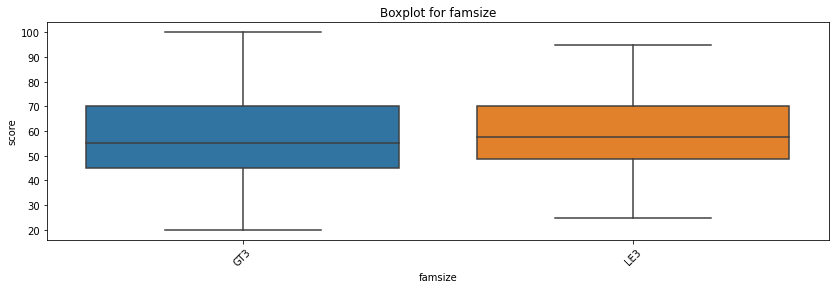

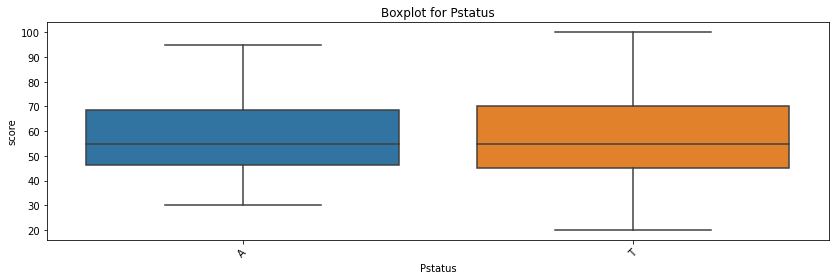

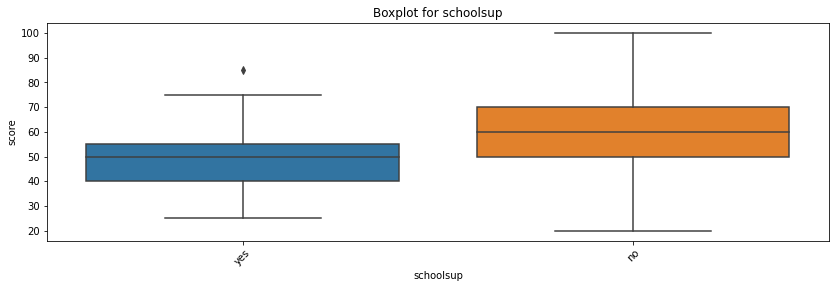

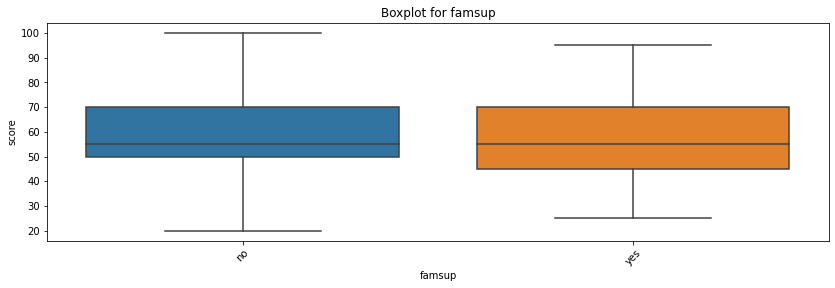

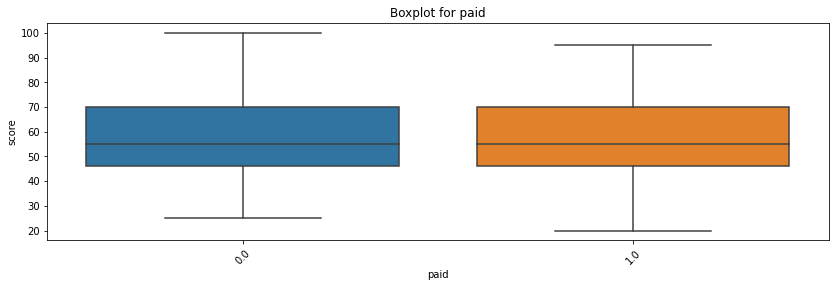

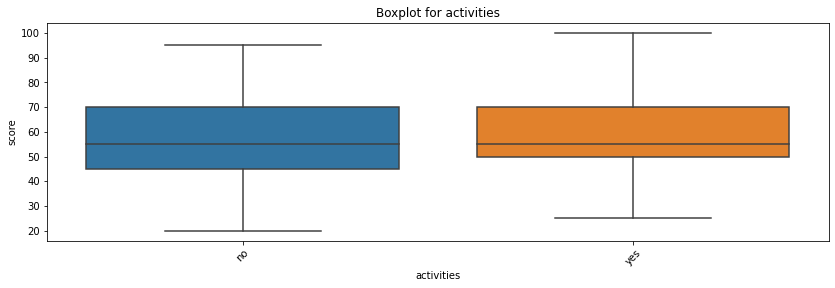

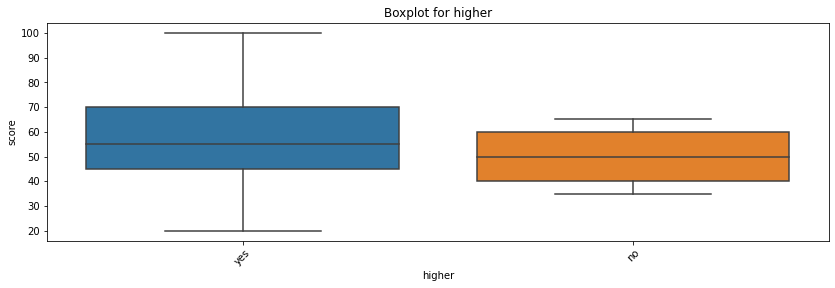

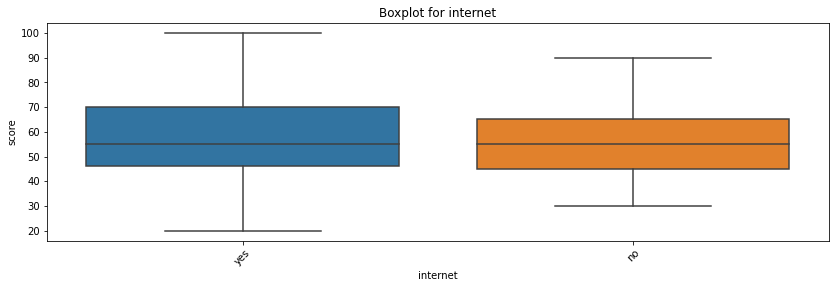

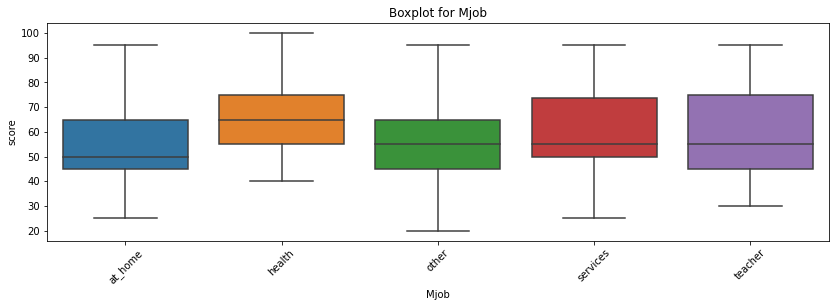

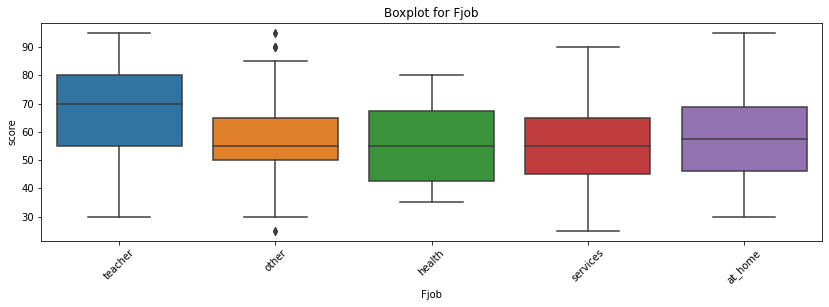

In [70]:
# 3. Дальше категориальные и дихотомические попытаемся сравнить с нашими оценками.
# Что-то я туплю и не могу найти функцию для расчета матожидания в питоне(не может же ее не быть о.О), поэтому ограничимся
# медианой для каждой группы.
# Но для начала просто посмотрим графики, все равно не понятно как однозначно интерпретировать эту медиану и их разницу
for col in ['famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'higher', 'internet', 'Mjob', 'Fjob']:
    get_boxplot(col)

In [ ]:
# Выводы. А и к черту эту медиану тогда, и так все видно. Ничего однозначного по этим данным не скажешь. Нужно больше данных.
# Оставим те данные, которые дают хоть какую-то разницу:
# "schoolsup" - с поддержкой ученики явно более плотно сдают экзамены. Видно, что лучших результатов они не достигают, это
# объяснимо, поддерживают туповатых. Зато и минимальные значения меньше, что точно говорит нам - если ученика поддерживают в школе, 
# у него будут более хорошие отметки, чем без поддержки

# 'famsup', видим похожую картину

# "paid" странно, что разница почти незаметна... Это реально странно, поэтому столбец оставим, будем наблюдать на большей выборке

# "activities" - минимум побольше, межквартильный интервал поменьше, т.е. более плотно ученики идут. Но все это такие сопли.

# "higher" - тут хорошее различие. Не в  основной массе оценок, но в разбросе. Кстати, выглядят эти данные искуственно.
# Если человек дальше не планирует вышку, что ему мешает учиться херово? Верно, ничто. Данные - фейковые. Ладно.
# Эти фейковые данные должны нас навести на мысль, что вышка бывает разная, поэтому такой большой разброс - есть те, кто выбрал
# связанную с математикой стезю, а есть те, которым математика не нужна. 

# "internet" - ну, по той же причине оставляем, разброс без интернета меньше. С чего бы, снова я задаюсь вопросом...
# Типа, если у тебя есть интеренет, у тебя есть возможность как найти инфу, так и тупить побольше? А без интернета не найти во что
# тупить? Я вот жил долго без интернета, у меня была масса способов филонить и не учиться... Идея вроде и реалистична, Но снова
# не верится.

# "Mjob, Fjob" тоже невразумительные какие-то скачки, почему-то health работа матери дает буст по математике... отказываюсь пока 
# это анализировать. Но в этот фактор я верю, он должен сыграть на бОльших и реальных данных.
# Почему они вообще отличаются у матери и отца по влиянию? Почему паттерн учителя-мамы не такой же как у учителя-отца 
# с широкими усами? 

In [72]:
# удаляем не отличающиеся по оценкам параметры
work_d.drop(['famsize', 'Pstatus'], axis=1, inplace=True)

In [76]:
# так, из любопытства. Считаем коэф Крамера для наших категориальных признаков
a = list(combinations(['famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'higher', 'internet',
                      'Mjob', 'Fjob'], 2))
for i in a:
    print('Коэф. Крамера для {} и {} равен {}'.format(i[0], i[1], cramers_v(data[i[0]], data[i[1]])))


Коэф. Крамера для famsize и Pstatus равен 0.03882895174528789
Коэф. Крамера для famsize и schoolsup равен 0.0
Коэф. Крамера для famsize и famsup равен 0.10223767164912434
Коэф. Крамера для famsize и paid равен 0.053205193013013914
Коэф. Крамера для famsize и activities равен 0.0
Коэф. Крамера для famsize и higher равен 0.0
Коэф. Крамера для famsize и internet равен 0.0
Коэф. Крамера для famsize и Mjob равен 0.012711934126918954
Коэф. Крамера для famsize и Fjob равен 0.0
Коэф. Крамера для Pstatus и schoolsup равен 0.0
Коэф. Крамера для Pstatus и famsup равен 0.0
Коэф. Крамера для Pstatus и paid равен 0.0
Коэф. Крамера для Pstatus и activities равен 0.07730583406897505
Коэф. Крамера для Pstatus и higher равен 0.0
Коэф. Крамера для Pstatus и internet равен 0.0
Коэф. Крамера для Pstatus и Mjob равен 0.0
Коэф. Крамера для Pstatus и Fjob равен 0.0
Коэф. Крамера для schoolsup и famsup равен 0.07179844742481511
Коэф. Крамера для schoolsup и paid равен 0.0
Коэф. Крамера для schoolsup и activiti

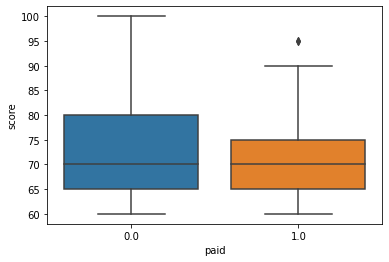

In [81]:
# Коэф Крамера = 0 - это случайные друг для друга параметры, 1 - полностью скоррелированы положительно, -1 - отрицательно.
# В общем, опять никаких корреляций существенных нет. И это странно.
# Поддержка семьи и оплата репетиторов, могла бы и повыше быть, например.
# Коэф. Крамера для Pstatus и famsup равен 0.0 - что тоже подозрительно. Больше семья - больше вероятность поддержки
# Коэф. Крамера для paid и Mjob равен 0.1738469539723301
# Коэф. Крамера для paid и Fjob равен 0.0 Это тоже необъяснимо. Почему при одинаковых работах такое различие между маминой и 
# папиной работами?
# Кстати, еще одна проверка на реальность результатов. Стремящиеся в вышку со средне-высокими балами по математике и репетитора
# посмотрим.
test = work_d[(work_d.score > work_d.score.mean()) & (work_d.higher == 'yes')]
sns.boxplot(x = 'paid', y = 'score', data = test)

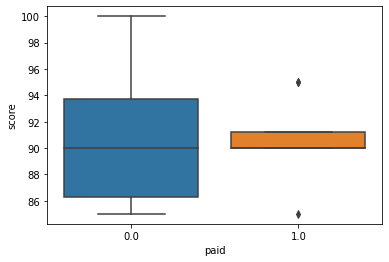

In [82]:
# Мм, смущает, что среди тех, кому репититора назначили и кто стремится в вышку связанную с матмематикой (почти наверняка),
# нет набравших больше балов, чем среди тех, кому не назначили.
# Смотрим еще более жестки условия
test2 = work_d[(work_d.score > 80) & (work_d.higher == 'yes')]
sns.boxplot(x = 'paid', y = 'score', data = test2)

In [84]:
# Эээ, что?
test2[test2.paid == 1.0]

,age,Medu,Fedu,Mjob,Fjob,studytime,schoolsup,famsup,paid,activities,d_k,higher,internet,famrel,freetime,goout,health,absences,score,school_score_av
8,15,4.0,3.0,services,other,2.0,no,yes,1.0,no,-6.0,yes,yes,NaN,2.0,2.0,1.0,0.0,95.0,58.215434
91,15,5.0,4.0,services,other,NaN,no,no,1.0,yes,NaN,yes,yes,4.0,5.0,5.0,1.0,4.0,90.0,58.215434
129,16,5.0,5.0,teacher,teacher,NaN,no,no,1.0,yes,NaN,yes,yes,3.0,5.0,5.0,4.0,NaN,90.0,58.215434
260,18,5.0,4.0,NaN,other,2.0,no,yes,1.0,no,-6.0,yes,yes,3.0,1.0,2.0,2.0,21.0,90.0,58.215434
265,18,4.0,5.0,NaN,other,2.0,no,yes,1.0,yes,-6.0,yes,yes,4.0,2.0,5.0,1.0,NaN,85.0,58.215434
286,18,3.0,NaN,at_home,at_home,3.0,no,yes,1.0,no,-9.0,yes,yes,4.0,3.0,3.0,2.0,5.0,95.0,58.215434
293,17,4.0,2.0,services,other,4.0,no,yes,1.0,no,-12.0,yes,no,3.0,1.0,2.0,3.0,6.0,90.0,58.215434
303,17,4.0,3.0,health,NaN,4.0,no,yes,1.0,yes,-12.0,yes,yes,5.0,2.0,2.0,5.0,0.0,90.0,58.215434


In [97]:
# Ну да, какие красивые цифры... Ровно 90 баллов, ни больше, ни меньше. 

# Данные - шляпа полная.
# Данные пересобрать на реальных людях. Добавить еще хотя бы 8 школ. Существенных зависимостей нет. Что-то можно выудить, написано
# по ходу работы, но все это бессмысленно, пока данных не будет больше и они не будут реальными.
# Добавить данные по среднему баллу по школе за прошлые года.
# Из предложенных взять параметры:
# 1. Возраст - надо понимать, на каком он этапе, корреляции с баллами не будет, но инфа полезная.
# 2. Остальные могут выстрелить, когда данные будут настоящими. Я бы выкинул famrel, health, freetime, которые хуже всех показали
# себя на Спирмане. Но выкидывать что-то на основании статистики, когда предполагаешь подлог данных, неправильно.
work_d.columns

Index(['age', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'studytime', 'schoolsup',
       'famsup', 'paid', 'activities', 'd_k', 'higher', 'internet', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score', 'school_score_av'],
      dtype='object')

In [100]:
# А, разбираемся с d_k колонкой. Тыкаем палкой
stats.spearmanr(work_d.d_k, work_d.score, nan_policy='omit')

SpearmanrResult(correlation=-0.12377349944923242, pvalue=0.02147679339248263)

In [101]:
stats.spearmanr(work_d.d_k, work_d.age, nan_policy='omit')

SpearmanrResult(correlation=-0.02843796536949504, pvalue=0.5954243112529711)

In [102]:
stats.spearmanr(work_d.d_k, work_d.absences, nan_policy='omit')

SpearmanrResult(correlation=0.07619019913933812, pvalue=0.16099220809288042)

In [113]:
# Нет корреляций с непрерывными параметрами. Вспоминаем, что у нас там было только 4 значения, смотрим на каждое
wtf12 = work_d[work_d.d_k == -12.0]

In [114]:
wtf12

,age,Medu,Fedu,Mjob,Fjob,studytime,schoolsup,famsup,paid,activities,d_k,higher,internet,famrel,freetime,goout,health,absences,score,school_score_av
47,16,5.0,4.0,health,NaN,4.0,no,no,0.0,yes,-12.0,yes,yes,4.0,2.0,2.0,2.0,4.0,100.0,58.215434
66,15,5.0,5.0,other,services,4.0,no,yes,0.0,yes,-12.0,yes,yes,1.0,3.0,3.0,3.0,4.0,60.0,58.215434
67,16,4.0,NaN,services,other,4.0,yes,yes,1.0,no,-12.0,yes,yes,4.0,3.0,3.0,5.0,4.0,30.0,58.215434
69,15,4.0,2.0,other,other,4.0,no,yes,0.0,no,-12.0,yes,yes,4.0,4.0,2.0,3.0,12.0,80.0,58.215434
70,16,4.0,2.0,other,other,4.0,no,yes,1.0,no,-12.0,yes,yes,4.0,3.0,2.0,5.0,0.0,75.0,58.215434
71,15,5.0,3.0,other,other,4.0,no,no,0.0,no,-12.0,yes,yes,3.0,3.0,3.0,3.0,0.0,50.0,58.215434
76,15,5.0,1.0,teacher,other,4.0,no,no,0.0,yes,-12.0,NaN,yes,3.0,4.0,3.0,1.0,8.0,50.0,58.215434
77,16,3.0,3.0,other,other,4.0,no,no,1.0,no,-12.0,yes,yes,5.0,2.0,3.0,3.0,0.0,55.0,58.215434
94,15,3.0,3.0,services,health,4.0,no,yes,0.0,yes,-12.0,yes,yes,NaN,3.0,4.0,4.0,6.0,70.0,58.215434
95,15,2.0,2.0,at_home,other,4.0,yes,yes,1.0,yes,-12.0,yes,yes,3.0,1.0,2.0,1.0,2.0,50.0,58.215434


In [105]:
wtf6 = work_d[work_d.d_k == -6.0]

In [115]:
# слишком длинный, проверям предположение
wtf6.studytime.value_counts()

2.0    178
Name: studytime, dtype: int64

In [107]:
wtf3 = work_d[work_d.d_k == -3.0]

In [116]:
wtf3.studytime.value_counts()

1.0    90
Name: studytime, dtype: int64

In [119]:
wtf9 = work_d[work_d.d_k == -9.0]
wtf9.studytime.value_counts()

3.0    59
Name: studytime, dtype: int64

In [117]:
# Ну ладно, а что там по всему дф
work_d.studytime.value_counts()

2.0    178
1.0     90
3.0     59
4.0     24
Name: studytime, dtype: int64

In [118]:
# ага. А 0 часов ни один школьник не занимался помимо школы? Ни один? Прямо ни один-ни один? И даже двоечники?
# Сколько же они занимались?
poor_score = work_d[work_d.score < work_d.score.quantile(0.25)]

,age,Medu,Fedu,Mjob,Fjob,studytime,schoolsup,famsup,paid,activities,d_k,higher,internet,famrel,freetime,goout,health,absences,score,school_score_av
0,18,5.0,5.0,at_home,teacher,2.0,yes,no,0.0,no,-6.0,yes,NaN,4.0,3.0,4.0,3.0,6.0,30.0,58.215434
1,17,2.0,2.0,at_home,other,2.0,no,yes,0.0,no,-6.0,yes,yes,5.0,3.0,3.0,3.0,4.0,30.0,58.215434
7,17,5.0,5.0,other,teacher,2.0,yes,yes,0.0,no,-6.0,yes,no,4.0,1.0,4.0,1.0,6.0,30.0,58.215434
18,17,4.0,3.0,services,services,1.0,no,yes,NaN,yes,-3.0,yes,yes,5.0,5.0,5.0,5.0,16.0,25.0,58.215434
24,15,3.0,5.0,services,health,3.0,yes,yes,1.0,yes,-9.0,yes,yes,4.0,3.0,2.0,5.0,NaN,40.0,58.215434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,18,3.0,2.0,other,other,1.0,no,no,0.0,yes,-3.0,yes,yes,4.0,4.0,3.0,5.0,5.0,35.0,54.268293
384,18,5.0,3.0,other,NaN,1.0,no,no,NaN,no,-3.0,yes,NaN,5.0,4.0,3.0,3.0,14.0,25.0,54.268293
386,18,5.0,5.0,teacher,at_home,1.0,no,yes,1.0,yes,-3.0,yes,yes,4.0,4.0,3.0,5.0,7.0,30.0,54.268293
388,18,4.0,2.0,teacher,services,2.0,no,yes,1.0,no,-6.0,yes,yes,4.0,3.0,4.0,1.0,0.0,40.0,54.268293


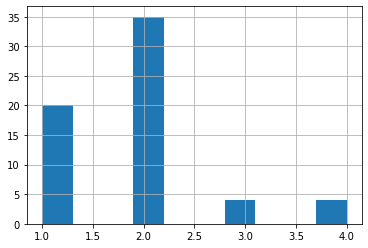

In [121]:
poor_score.studytime.hist()
# Ладно, это уже мне ни о чем не говорит.

In [122]:
# а вот еще одно предположение
work_d.score.unique()

array([ 30.,  50.,  75.,  55.,  95.,  45.,  60.,  70.,  80.,  25.,  40.,
        85.,  90.,  65., 100.,  35.,  nan,  20.])

In [ ]:
# ..................шляпа. анализ закончил. gigo.
# А, забыл - столбец d_k - копия столбца с часами внешкольных занятий, выкинуть.